In [1]:
import matplotlib.pyplot as plt
import scanpy as sc

import os
from PIL import Image
import pathlib
import anndata as ad
import pandas as pd
import sys

import eggplant as eg

sc.set_figure_params(figsize=(4, 4), frameon=False)

%load_ext lab_black

In [2]:
root = pathlib.Path("/Users/giovanni.palla/Datasets/advomics")
ref_img = Image.open(root / "dev-heart.png")
ref_lmk = pd.read_csv(root / "dev-heart_landmarks.tsv", sep="\t", header=0, index_col=0)

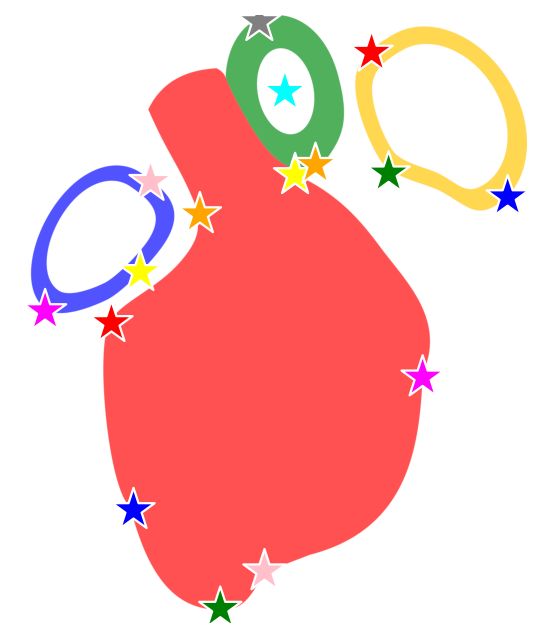

In [3]:
plt.figure(figsize=(5, 5))
lmk_cmap = eg.constants.LANDMARK_CMAP
cmap = eg.pl.ColorMapper(lmk_cmap)

plt.imshow(ref_img, alpha=0.7)
plt.scatter(
    ref_lmk.values[:, 0],
    ref_lmk.values[:, 1],
    marker="*",
    edgecolor="white",
    c=cmap(ref_lmk),
    s=400,
)
plt.axis("off")
plt.show()

In [4]:
grid_crd, mta = eg.pp.reference_to_grid(
    ref_img,
    n_approx_points=1000,
    n_regions=1,
)

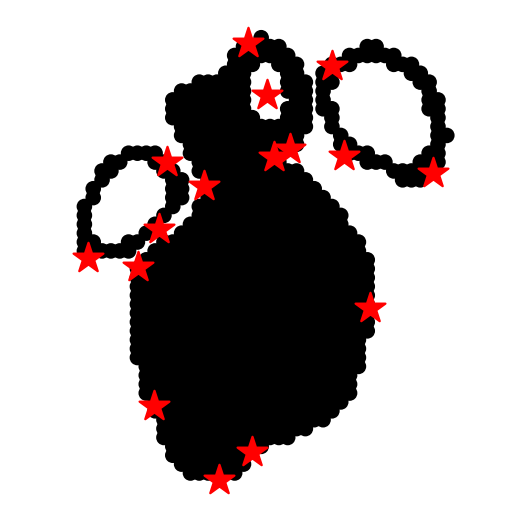

In [5]:
plt.scatter(
    grid_crd[:, 0],
    grid_crd[:, 1],
    c=mta,
    cmap=plt.cm.binary_r,
)

plt.scatter(
    ref_lmk.values[:, 0],
    ref_lmk.values[:, 1],
    marker="*",
    c="red",
    s=200,
)
plt.gca().invert_yaxis()
plt.axis("equal")
plt.axis("off")
plt.show()

In [17]:
ref = eg.m.Reference(
    grid_crd,
    landmarks=ref_lmk.values,
    meta=dict(region=mta),
)

In [20]:
adata_files = os.listdir(root / "spatial_adata")
adata_files
adatas = {
    f.strip(".h5ad"): sc.read(root / f"spatial_adata/{f}") for f in adata_files[0:3]
}

Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.


In [30]:
all_genes = []
for adata in adatas.values():
    sc.pp.highly_variable_genes(
        adata, n_top_genes=1000, subset=False, flavor="seurat_v3"
    )
    all_genes.append(
        adata.var["highly_variable"].index[adata.var["highly_variable"]].tolist()
    )
unique_genes = list(set.intersection(*map(set, all_genes)))
unique_genes[0:10]

['PRG4',
 'EGFL7',
 'COX6A2',
 'COL1A1',
 'ADAMTS8',
 'SLC27A6',
 'THBS2',
 'HBE1',
 'MSLN',
 'BMP2']

In [31]:
for adata in adatas.values():
    eg.pp.default_normalization(
        adata, min_cells=0.1, total_counts=1e4, exclude_highly_expressed=False
    )

    eg.pp.match_scales(adata, ref)
    eg.pp.get_landmark_distance(adata, reference=ref)

    eg.pp.spatial_smoothing(adata)

Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.


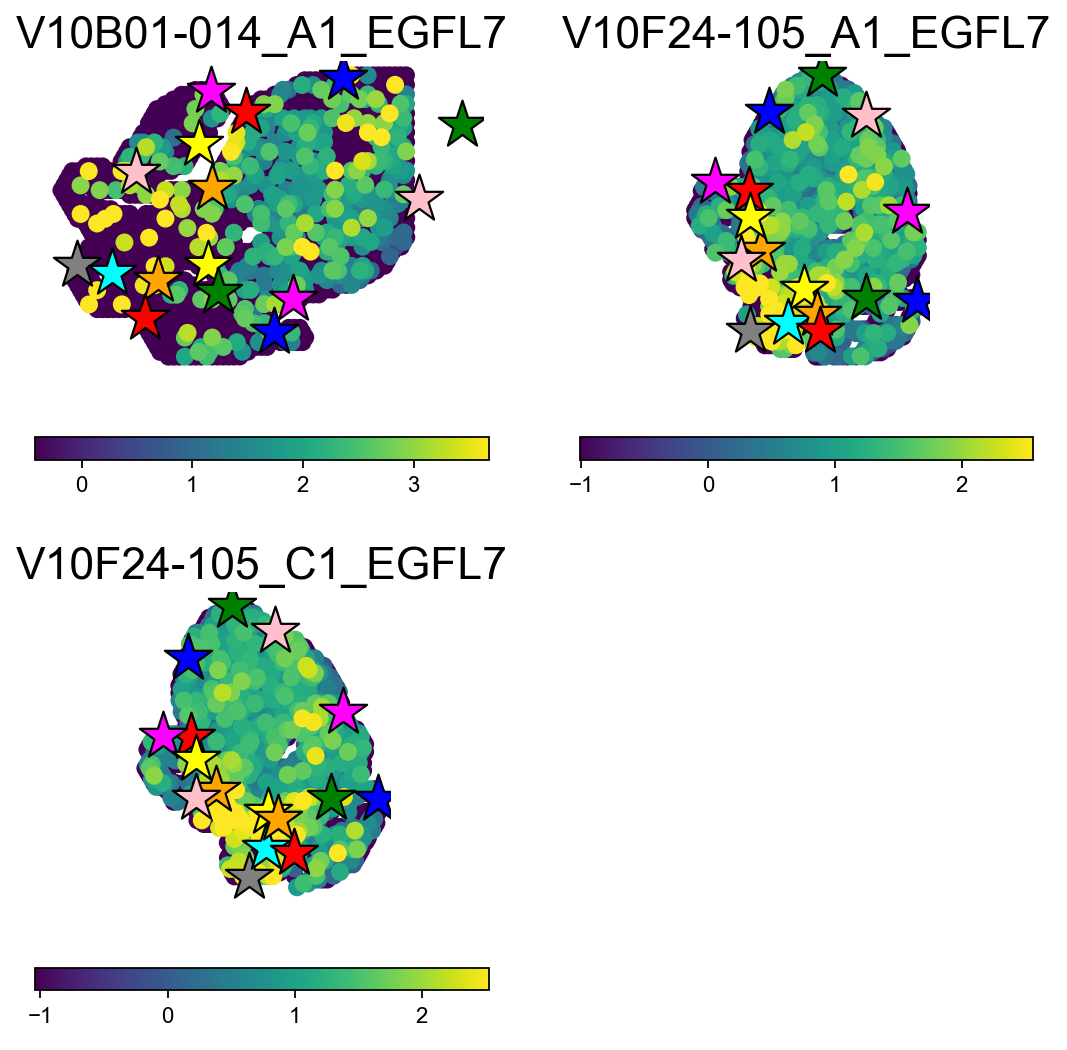

In [33]:
eg.pl.visualize_observed(
    adatas,
    features="EGFL7",
    n_rows=2,
    include_title=True,
    fontsize=20,
    marker_size=[50] * 5 + [80] * 7,
    share_colorscale=False,
    separate_colorbar=False,
    colorbar_fontsize=10,
    side_size=4,
    show_landmarks=True,
    quantile_scaling=True,
)

In [54]:
losses = eg.fun.transfer_to_reference(
    adatas,
    reference=ref,
    layer="smoothed",
    features=unique_genes[0:3],
    n_epochs=500,
    device="cpu",
    verbose=True,
)

[Processing] ::  Model : V10B01-014_A1 | Feature : PRG4 | Transfer : 1/9


  3%|████▉                                                                                                                                                               | 15/500 [00:04<02:20,  3.46it/s]

KeyboardInterrupt



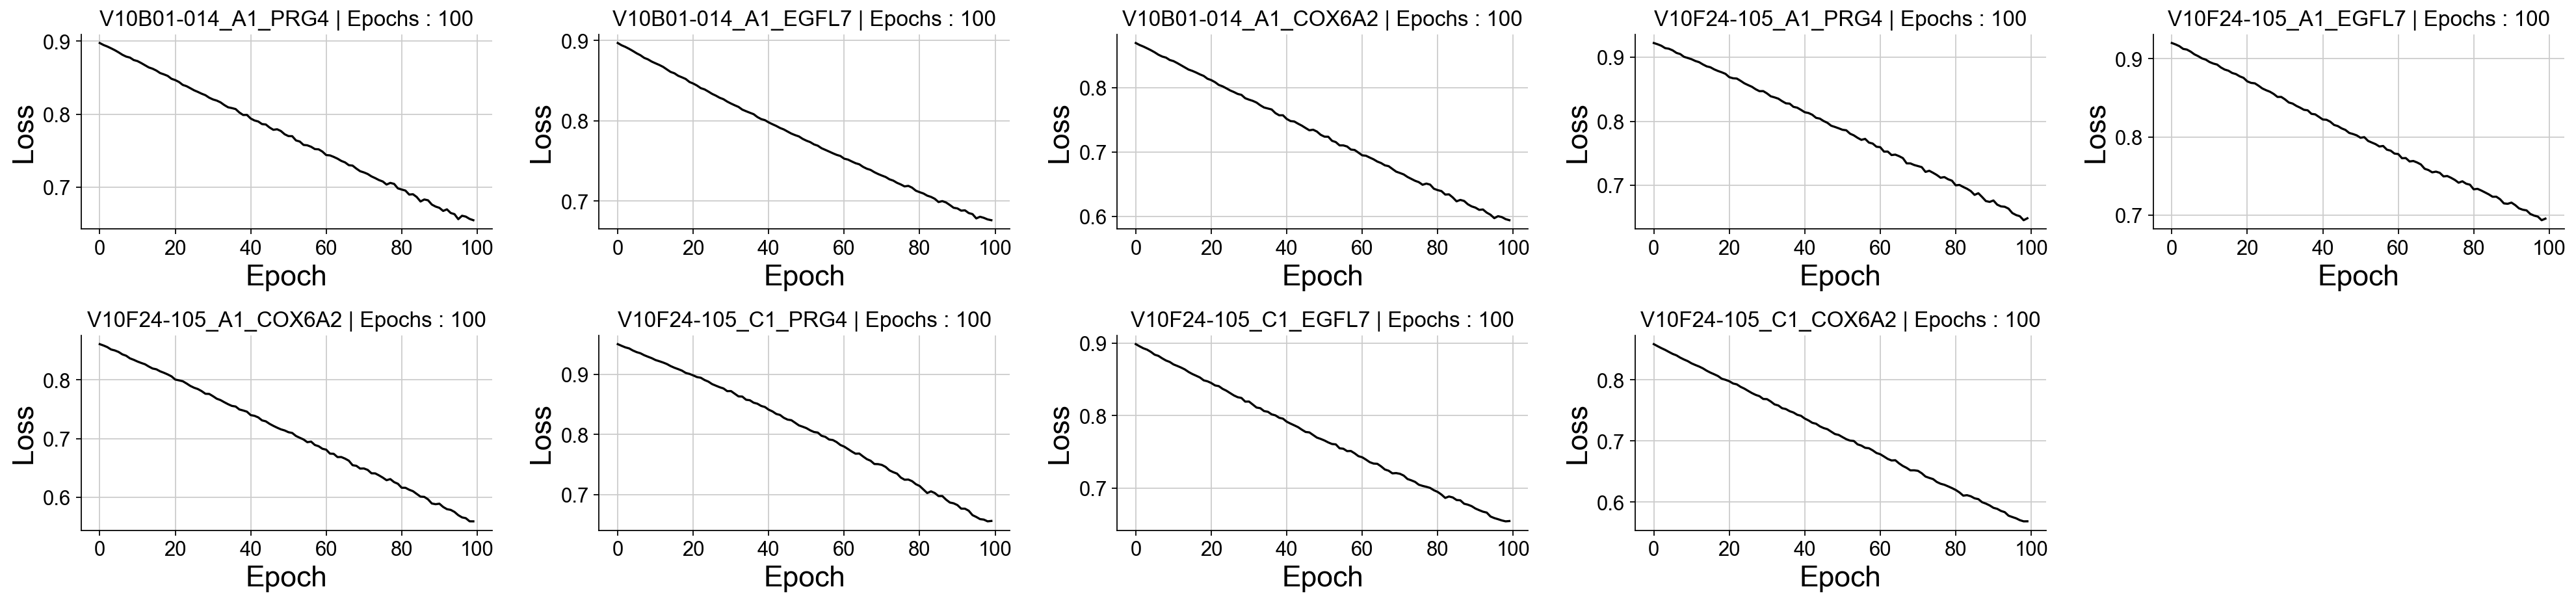

In [36]:
eg.pl.model_diagnostics(losses=losses)

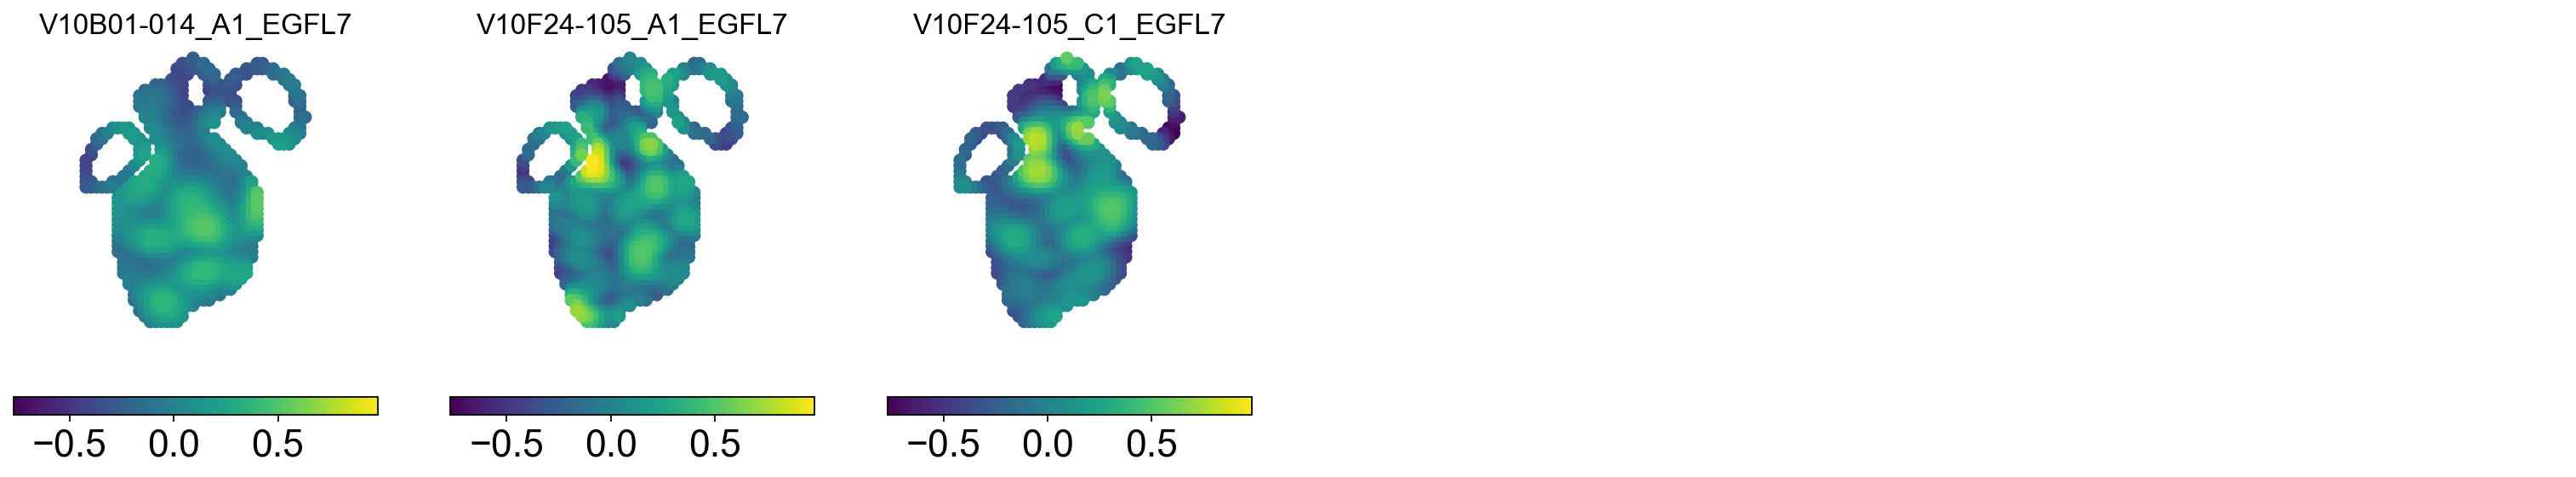

In [37]:
eg.pl.visualize_transfer(
    ref,
    n_cols=6,
    attributes="EGFL7",
    include_title=True,
    fontsize=15,
    marker_size=35,
    share_colorscale=True,
    separate_colorbar=False,
    colorbar_fontsize=20,
    side_size=4,
    show_landmarks=False,
    flip_y=True,
    quantile_scaling=False,
)

In [52]:
ref.adata.var

,model,feature
V10B01-014_A1_PRG4,V10B01-014_A1,PRG4
V10B01-014_A1_EGFL7,V10B01-014_A1,EGFL7
V10B01-014_A1_COX6A2,V10B01-014_A1,COX6A2
V10F24-105_A1_PRG4,V10F24-105_A1,PRG4
V10F24-105_A1_EGFL7,V10F24-105_A1,EGFL7
V10F24-105_A1_COX6A2,V10F24-105_A1,COX6A2
V10F24-105_C1_PRG4,V10F24-105_C1,PRG4
V10F24-105_C1_EGFL7,V10F24-105_C1,EGFL7
V10F24-105_C1_COX6A2,V10F24-105_C1,COX6A2
composite_COX6A2,composite,COX6A2


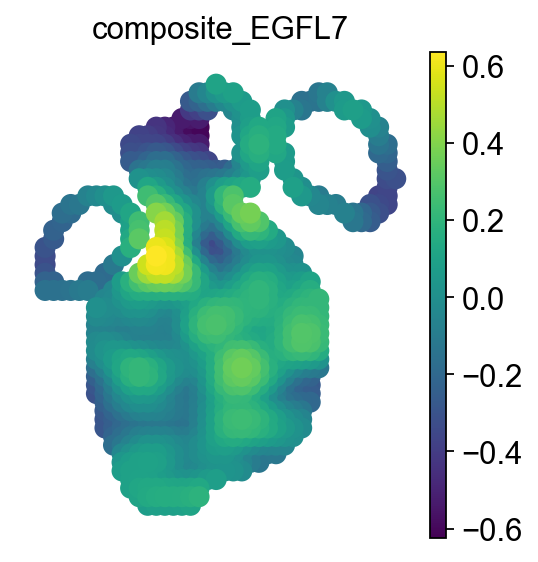

In [53]:
sc.pl.spatial(ref.adata, spot_size=0.05, color="composite_EGFL7")

In [38]:
res = eg.sdea.sdea(
    ref.adata,
    group_col="feature",
    n_std=2,
)

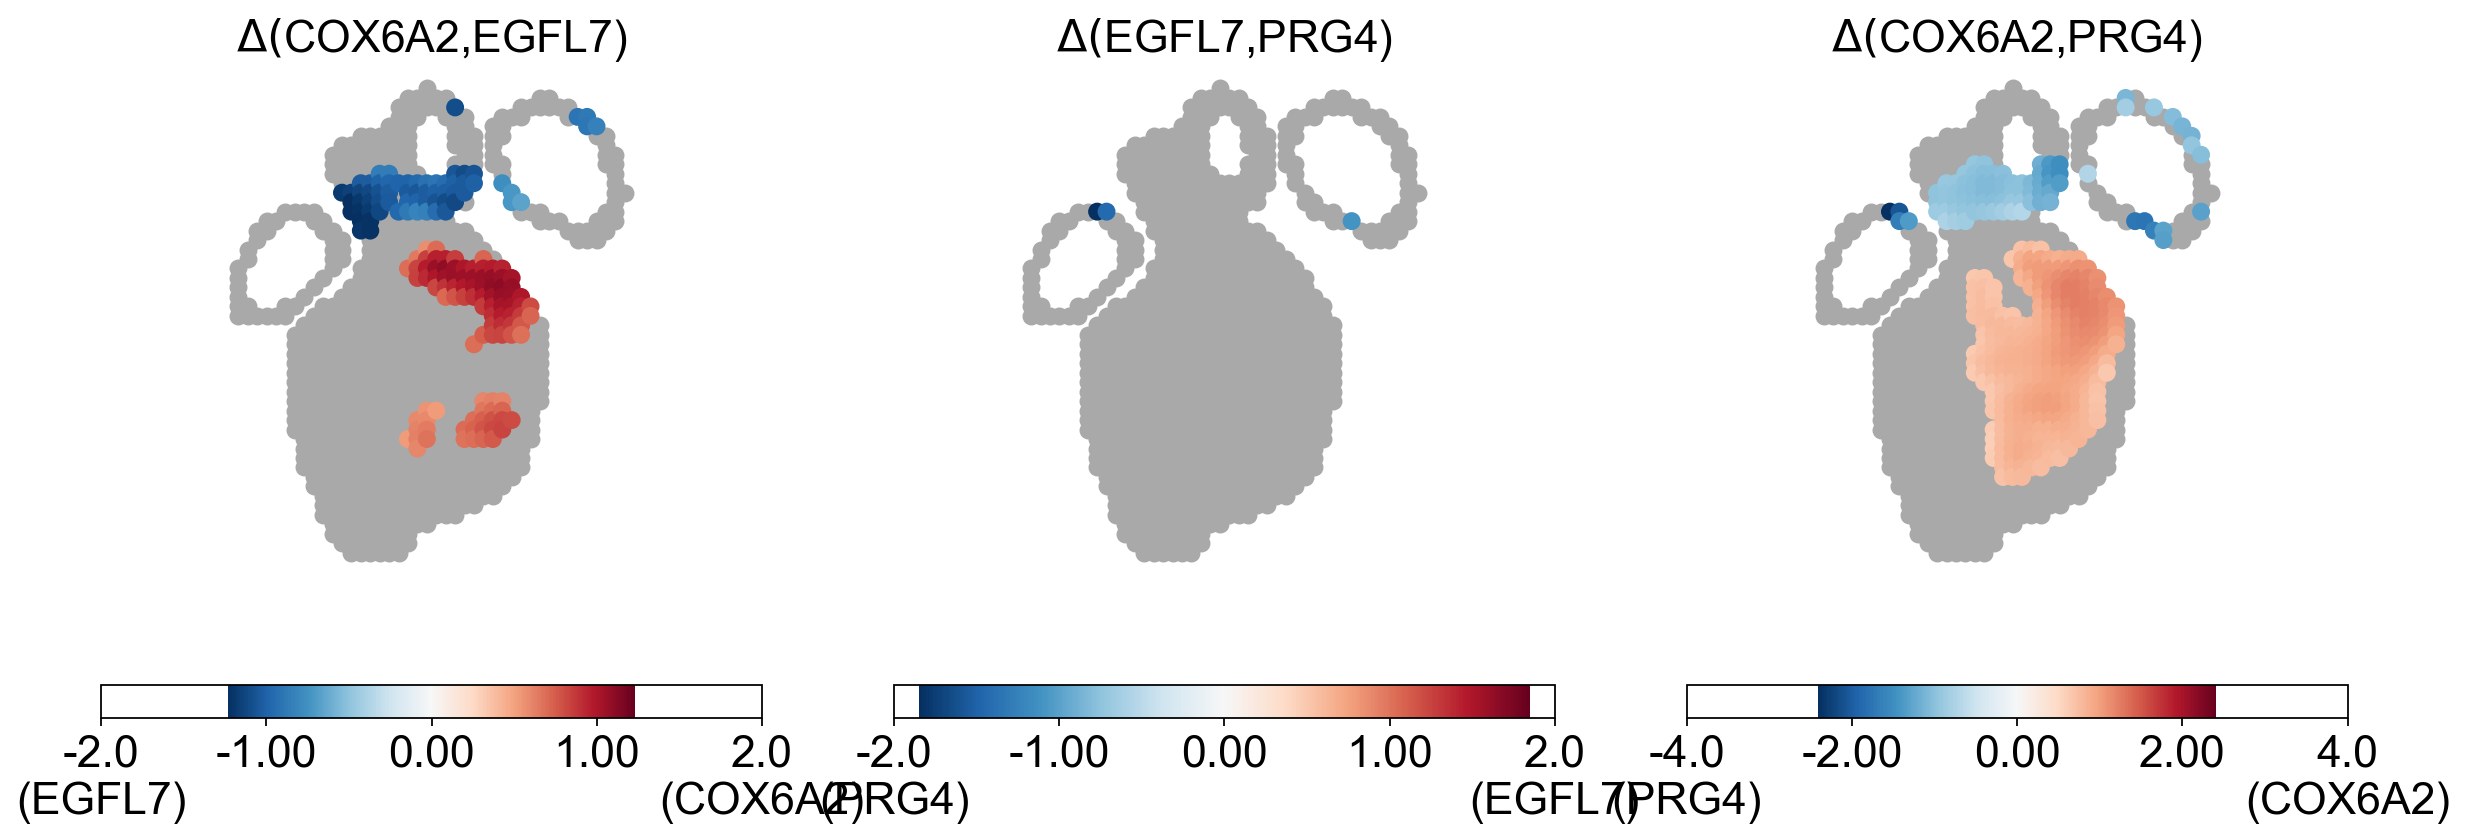

In [39]:
fig, ax = eg.pl.visualize_sdea_results(
    ref,
    res,
    n_cols=3,
    marker_size=50,
    side_size=6,
    colorbar_orientation="horizontal",
    title_fontsize=20,
    colorbar_fontsize=20,
    no_sig_color="darkgray",
    reorder_axes=[0, 2, 1],
)

In [40]:
ref.composite_representation(by="feature")

/Users/giovanni.palla/miniconda3/envs/advomics/lib/python3.8/site-packages/anndata/utils.py:141: UserWarning: X converted to numpy array with dtype float64
  warnings.warn(f"{name} converted to numpy array with dtype {arr.dtype}")
/Users/giovanni.palla/miniconda3/envs/advomics/lib/python3.8/site-packages/anndata/utils.py:141: UserWarning: Layer 'var' converted to numpy array with dtype float64
  warnings.warn(f"{name} converted to numpy array with dtype {arr.dtype}")


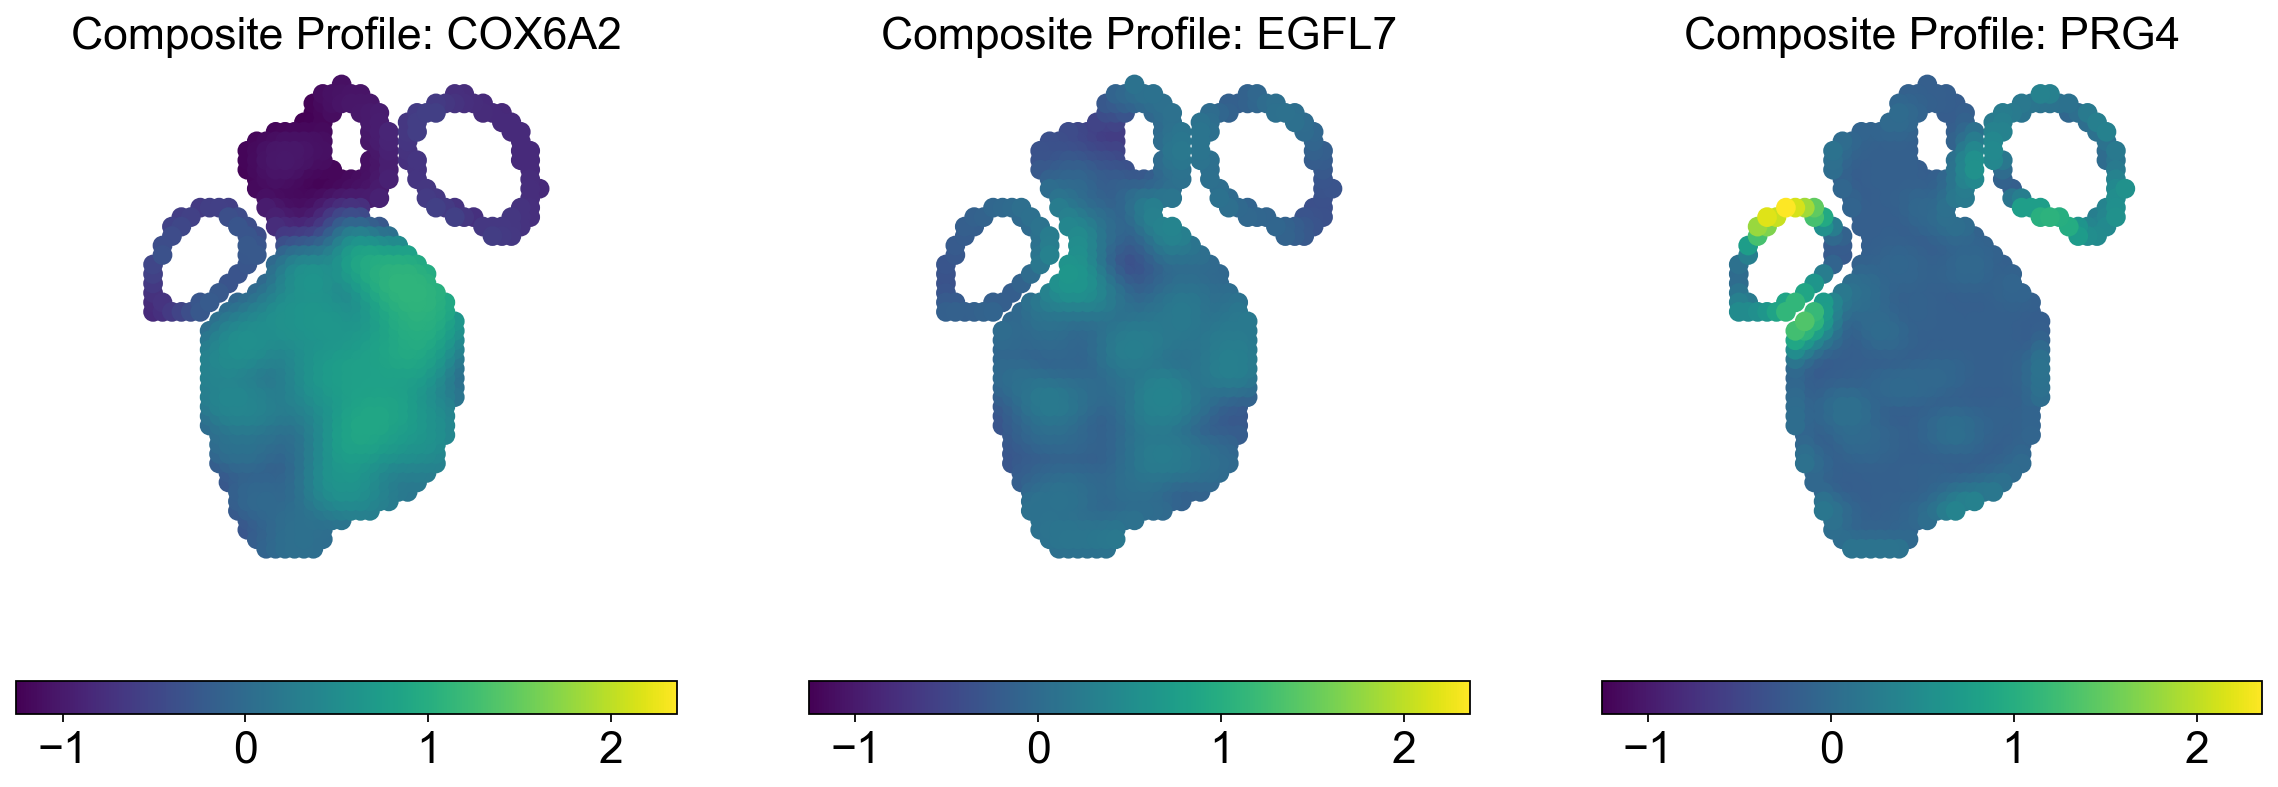

In [41]:
eg.pl.visualize_transfer(
    ref,
    attributes="composite",
    n_cols=3,
    include_title=True,
    fontsize=20,
    colorbar_fontsize=20,
    marker_size=62,
    share_colorscale=True,
    separate_colorbar=False,
    side_size=6,
    show_landmarks=False,
    flip_y=True,
    quantile_scaling=False,
)